# <center> 【Kaggle】Telco Customer Churn

In [ ]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# 实用函数
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

from tqdm import tqdm

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义模块
from telcoFunc import *
# 导入特征衍生模块
import features_creation as fc
from features_creation import *

# re模块相关
import inspect, re

# 其他模块
from tqdm import tqdm
import gc

In [ ]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

# 连续字段转化
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

# 缺失值填补
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

# 标签值手动转化
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [ ]:
features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

In [ ]:
# 划分训练集和测试集
train, test = train_test_split(tcc, random_state=23)

X_train = train.drop(columns=[ID_col, target]).copy()
X_test = test.drop(columns=[ID_col, target]).copy()

y_train = train['Churn'].copy()
y_test = test['Churn'].copy()

X_train_seq = pd.DataFrame()
X_test_seq = pd.DataFrame()

# 年份衍生
X_train_seq['tenure_year'] = ((72 - X_train['tenure']) // 12) + 2014
X_test_seq['tenure_year'] = ((72 - X_test['tenure']) // 12) + 2014

# 月份衍生
X_train_seq['tenure_month'] = (72 - X_train['tenure']) % 12 + 1
X_test_seq['tenure_month'] = (72 - X_test['tenure']) % 12 + 1

# 季度衍生
X_train_seq['tenure_quarter'] = ((X_train_seq['tenure_month']-1) // 3) + 1
X_test_seq['tenure_quarter'] = ((X_test_seq['tenure_month']-1) // 3) + 1

# 独热编码
enc = preprocessing.OneHotEncoder()
enc.fit(X_train_seq)

seq_new = list(X_train_seq.columns)

# 创建带有列名称的独热编码之后的df
X_train_seq = pd.DataFrame(enc.transform(X_train_seq).toarray(),
                           columns = cate_colName(enc, seq_new, drop=None))

X_test_seq = pd.DataFrame(enc.transform(X_test_seq).toarray(),
                          columns = cate_colName(enc, seq_new, drop=None))

# 调整index
X_train_seq.index = X_train.index
X_test_seq.index = X_test.index

In [ ]:
ord_enc = OrdinalEncoder()
ord_enc.fit(X_train[category_cols])

X_train_OE = pd.DataFrame(ord_enc.transform(X_train[category_cols]), columns=category_cols)
X_train_OE.index = X_train.index
X_train_OE = pd.concat([X_train_OE, X_train[numeric_cols]], axis=1)

X_test_OE = pd.DataFrame(ord_enc.transform(X_test[category_cols]), columns=category_cols)
X_test_OE.index = X_test.index
X_test_OE = pd.concat([X_test_OE, X_test[numeric_cols]], axis=1)

In [ ]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until al

In [ ]:
# 准备数据集
X = np.array([[1, 1], [2, 2], [2, 1], [1, 2], [1, 1], [1, 2], [1, 2], [2, 1]])
X = pd.DataFrame(X, columns=['x0', 'x1'])
y = np.array([0, 0, 0, 1, 0, 1, 1, 0])

X,y

(   x0  x1
 0   1   1
 1   2   2
 2   2   1
 3   1   2
 4   1   1
 5   1   2
 6   1   2
 7   2   1,
 array([0, 0, 0, 1, 0, 1, 1, 0]))

[Text(0.4, 0.8333333333333334, 'X[1] <= 1.5\ngini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.6, 0.5, 'X[0] <= 1.5\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]')]

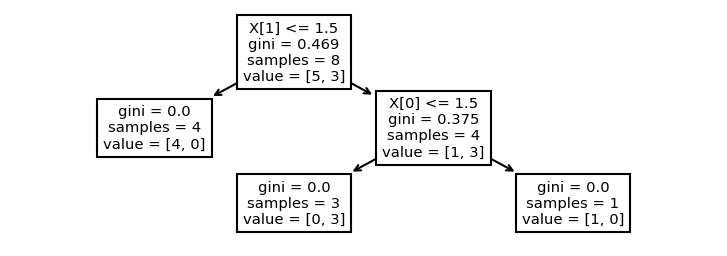

In [ ]:
clf = DecisionTreeClassifier().fit(X, y)
plt.figure(figsize=(6, 2), dpi=150)
tree.plot_tree(clf)

In [ ]:
clf.feature_importances_

array([0.4, 0.6])

In [ ]:
FI_x0 = (4 * 0.375) / 8
FI_x1 = (8 * 0.469 - 4 * 0.375) / 8

FI_x0, FI_x1

(0.1875, 0.2815)

In [ ]:
FI_x0/(FI_x0+FI_x1), FI_x1/(FI_x0+FI_x1)

(0.39978678038379534, 0.6002132196162047)

In [ ]:
clf = DecisionTreeClassifier().fit(X_train_OE, y_train)
clf.feature_importances_

array([0.02727689, 0.01658065, 0.02058534, 0.01486696, 0.00308123,
       0.01510983, 0.02463827, 0.04888942, 0.01590034, 0.01387519,
       0.01621799, 0.00947659, 0.01659499, 0.17219693, 0.02503379,
       0.04672867, 0.09925022, 0.18879121, 0.22490549])

In [ ]:
s1 = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
s1

TotalCharges        0.224905
MonthlyCharges      0.188791
Contract            0.172197
tenure              0.099250
OnlineSecurity      0.048889
PaymentMethod       0.046729
gender              0.027277
PaperlessBilling    0.025034
InternetService     0.024638
Partner             0.020585
StreamingMovies     0.016595
SeniorCitizen       0.016581
TechSupport         0.016218
OnlineBackup        0.015900
MultipleLines       0.015110
Dependents          0.014867
DeviceProtection    0.013875
StreamingTV         0.009477
PhoneService        0.003081
dtype: float64

In [ ]:
clf = DecisionTreeClassifier().fit(X_train_OE, y_train)
clf.feature_importances_

array([0.02615012, 0.01897285, 0.02160852, 0.01841412, 0.00340157,
       0.01472038, 0.0244306 , 0.04968895, 0.01821232, 0.0122789 ,
       0.01896473, 0.00943813, 0.01733306, 0.17219693, 0.02458266,
       0.04597754, 0.10512561, 0.17516754, 0.22333546])

In [ ]:
s2 = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
s2

TotalCharges        0.223335
MonthlyCharges      0.175168
Contract            0.172197
tenure              0.105126
OnlineSecurity      0.049689
PaymentMethod       0.045978
gender              0.026150
PaperlessBilling    0.024583
InternetService     0.024431
Partner             0.021609
SeniorCitizen       0.018973
TechSupport         0.018965
Dependents          0.018414
OnlineBackup        0.018212
StreamingMovies     0.017333
MultipleLines       0.014720
DeviceProtection    0.012279
StreamingTV         0.009438
PhoneService        0.003402
dtype: float64

In [ ]:
clf = DecisionTreeClassifier().fit(X_train_OE, y_train)
clf.feature_importances_

array([0.02222983, 0.02118631, 0.02476213, 0.01671562, 0.00322323,
       0.01408272, 0.02620733, 0.04766841, 0.01702756, 0.01174515,
       0.01968234, 0.01017574, 0.01486987, 0.17219693, 0.02682492,
       0.0394415 , 0.10560986, 0.19018292, 0.21616765])

In [ ]:
s3 = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
s3

TotalCharges        0.216168
MonthlyCharges      0.190183
Contract            0.172197
tenure              0.105610
OnlineSecurity      0.047668
PaymentMethod       0.039442
PaperlessBilling    0.026825
InternetService     0.026207
Partner             0.024762
gender              0.022230
SeniorCitizen       0.021186
TechSupport         0.019682
OnlineBackup        0.017028
Dependents          0.016716
StreamingMovies     0.014870
MultipleLines       0.014083
DeviceProtection    0.011745
StreamingTV         0.010176
PhoneService        0.003223
dtype: float64

In [ ]:
clf.score(X_train_OE, y_train), clf.score(X_test_OE, y_test)

(0.9982960999621355, 0.7353776263486655)

In [ ]:
df_temp = pd.DataFrame({'tree-s1':s1.index, 'tree-s2':s2.index, 'tree-s3':s3.index})
df_temp

,tree-s1,tree-s2,tree-s3
0,TotalCharges,TotalCharges,TotalCharges
1,MonthlyCharges,MonthlyCharges,MonthlyCharges
2,Contract,Contract,Contract
3,tenure,tenure,tenure
4,OnlineSecurity,OnlineSecurity,OnlineSecurity
5,PaymentMethod,PaymentMethod,PaymentMethod
6,gender,gender,PaperlessBilling
7,PaperlessBilling,PaperlessBilling,InternetService
8,InternetService,InternetService,Partner
9,Partner,Partner,gender


In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
mask = [True]*len(category_cols) + [False]*len(numeric_cols)
mask

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False]

In [ ]:
MI = mutual_info_classif(X_train_OE, y_train, discrete_features=mask, random_state=22)
MI

array([2.51869556e-05, 1.23816755e-02, 1.12934840e-02, 1.44750232e-02,
       2.29431150e-05, 5.93559150e-04, 5.44435344e-02, 6.73003276e-02,
       4.99549593e-02, 4.58322554e-02, 6.38268975e-02, 3.31442443e-02,
       3.33677529e-02, 1.01588946e-01, 1.95195236e-02, 4.64175293e-02,
       6.56956879e-02, 5.14837211e-02, 4.64057620e-02])

In [ ]:
s4 = pd.Series(MI, index=clf.feature_names_in_).sort_values(ascending=False)
s4

Contract            0.101589
OnlineSecurity      0.067300
tenure              0.065696
TechSupport         0.063827
InternetService     0.054444
MonthlyCharges      0.051484
OnlineBackup        0.049955
PaymentMethod       0.046418
TotalCharges        0.046406
DeviceProtection    0.045832
StreamingMovies     0.033368
StreamingTV         0.033144
PaperlessBilling    0.019520
Dependents          0.014475
SeniorCitizen       0.012382
Partner             0.011293
MultipleLines       0.000594
gender              0.000025
PhoneService        0.000023
dtype: float64

In [ ]:
df_temp['MI'] = s4.index
df_temp

,tree-s1,tree-s2,tree-s3,MI
0,TotalCharges,TotalCharges,TotalCharges,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity
2,Contract,Contract,Contract,tenure
3,tenure,tenure,tenure,TechSupport
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges
9,Partner,Partner,gender,DeviceProtection


In [ ]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [ ]:
# 实例化网格搜索评估器
tree_search = GridSearchCV(estimator = tree_model,
                           param_grid = tree_param,
                           n_jobs = 12)

In [ ]:
tree_search.fit(X_train_OE, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [ ]:
# 查看最优参数组
tree_search.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
# 查看验证集准确率均值
tree_search.best_score_

0.7925029027264128

In [ ]:
# 查看训练集整体准确率
tree_search.score(X_train_OE, y_train)

0.8014009844755774

In [ ]:
# 查看测试集准确率
tree_search.score(X_test_OE, y_test)

0.7938671209540034

In [ ]:
tree_search.best_estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07893377, 0.14119719, 0.        , 0.        ,
       0.        , 0.        , 0.02460464, 0.55635763, 0.        ,
       0.00930132, 0.11528793, 0.02646592, 0.0478516 ])

In [ ]:
tree_search.best_estimator_.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [ ]:
ss = pd.Series(tree_search.best_estimator_.feature_importances_, index=tree_search.best_estimator_.feature_names_in_).sort_values(ascending=False)
ss

Contract            0.556358
OnlineSecurity      0.141197
tenure              0.115288
InternetService     0.078934
TotalCharges        0.047852
MonthlyCharges      0.026466
StreamingMovies     0.024605
PaymentMethod       0.009301
StreamingTV         0.000000
PaperlessBilling    0.000000
gender              0.000000
TechSupport         0.000000
SeniorCitizen       0.000000
OnlineBackup        0.000000
MultipleLines       0.000000
PhoneService        0.000000
Dependents          0.000000
Partner             0.000000
DeviceProtection    0.000000
dtype: float64

In [ ]:
df_temp['tree-search'] = ss.index
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity
2,Contract,Contract,Contract,tenure,tenure
3,tenure,tenure,tenure,TechSupport,InternetService
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling


In [ ]:
mask = tree_search.best_estimator_.feature_importances_ != 0
mask

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False,  True,  True, False,  True,  True,  True,
        True])

In [ ]:
tree_search.best_estimator_.feature_names_in_[mask]

array(['InternetService', 'OnlineSecurity', 'StreamingMovies', 'Contract',
       'PaymentMethod', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

In [ ]:
X_train_OE_part = X_train_OE[tree_search.best_estimator_.feature_names_in_[mask]]

In [ ]:
X_train_OE_part.head()

,InternetService,OnlineSecurity,StreamingMovies,Contract,PaymentMethod,tenure,MonthlyCharges,TotalCharges
1936,0.0,2.0,0.0,1.0,0.0,51,60.50,3145.15
6999,0.0,2.0,0.0,0.0,3.0,3,35.45,106.85
5863,1.0,0.0,2.0,0.0,2.0,21,97.35,2119.50
131,0.0,2.0,2.0,0.0,1.0,25,58.60,1502.65
3015,0.0,2.0,2.0,2.0,2.0,59,86.75,5186.00


In [ ]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,25, 1).tolist()}

In [ ]:
# 实例化网格搜索评估器
tree_search1 = GridSearchCV(estimator = tree_model,
                            param_grid = tree_param,
                            n_jobs = 12)

In [ ]:
tree_search1.fit(X_train_OE_part, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19, 20, 21, 22, 23, 24],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [ ]:
# 查看特征子集的建模结果
tree_search1.best_score_

0.7947763467217108

In [ ]:
tree_search1.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 6,
 'max_leaf_nodes': 19,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
# 查看原始特征的建模结果
tree_search.best_score_

0.7925029027264128

In [ ]:
tree_search1.best_estimator_.feature_importances_

array([0.07662396, 0.13706538, 0.02388465, 0.54007714, 0.00902914,
       0.1188095 , 0.03953651, 0.05497371])

## Recursive feature elimination（RFE）

- Step 1：根据给定的评估器，在当前数据集A1上进行训练并计算每个特征的重要性，即计算每个特征的coef_或feature_importances_；
- Step 2：剔除最不重要的特征，即特征重要性计算结果最小的特征，得到特征子集A2，然后再次训练模型，并计算剩余特征的特征重要性；
- Step 3：不断重复Step 2，直到特征子集的个数等于n_features_to_select，其中n_features_to_select是人工设置的最终保留特征个数。

In [ ]:
from sklearn.feature_selection import RFE

| 参数 | 解释 | 说明 |
| ------ | ------ | ------ |
| estimator | 带入训练的评估器 | 必须要能输出特征重要性指标 |
| n_features_to_select | 筛选后特征个数 | 默认保留一半 |
| step | 每次剔除特征的个数 | 默认每轮剔除1个特征 |
| importance_getter | 特征重要性评估指标 | 默认情况是coef_或者feature_importances_ |

In [ ]:
RFE?

Init signature:
RFE(
    estimator,
    *,
    n_features_to_select=None,
    step=1,
    verbose=0,
    importance_getter='auto',
)
Docstring:     
Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the
coefficients of a linear model), the goal of recursive feature elimination
(RFE) is to select features by recursively considering smaller and smaller
sets of features. First, the estimator is trained on the initial set of
features and the importance of each feature is obtained either through
any specific attribute or callable.
Then, the least important features are pruned from current set of features.
That procedure is recursively repeated on the pruned set until the desired
number of features to select is eventually reached.

Read more in the :ref:`User Guide <rfe>`.

Parameters
----------
estimator : ``Estimator`` instance
    A supervised learning estimator with a ``fit`` method that provides
    information about

In [ ]:
# 实例化评估器
tree_rfe = DecisionTreeClassifier()
rfe = RFE(estimator=tree_rfe)

In [ ]:
rfe.fit(X_train_OE, y_train)

RFE(estimator=DecisionTreeClassifier())

In [ ]:
# 总特征个数
rfe.n_features_in_

19

In [ ]:
# 筛选后特征个数
rfe.n_features_

9

In [ ]:
rfe.get_support()

array([ True, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True])

In [ ]:
rfe.feature_names_in_[rfe.get_support()]

array(['gender', 'InternetService', 'OnlineSecurity', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [ ]:
rfe.get_feature_names_out()

array(['gender', 'InternetService', 'OnlineSecurity', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [ ]:
rfe.ranking_

array([ 1,  5,  2,  6, 11,  7,  1,  1,  3,  9,  4, 10,  8,  1,  1,  1,  1,
        1,  1])

In [ ]:
rfe.ranking_ == 1

array([ True, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True])

In [ ]:
(rfe.ranking_ == 1) == rfe.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
rfe.predict(X_train_OE)

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [ ]:
rfe.score(X_train_OE, y_train)

0.9979174555092768

In [ ]:
rfe.score(X_test_OE, y_test)

0.7336740488358887

In [ ]:
rfe.get_feature_names_out()

array(['gender', 'InternetService', 'OnlineSecurity', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [ ]:
X_train_OE[rfe.get_feature_names_out()]

,gender,InternetService,OnlineSecurity,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
1936,0.0,0.0,2.0,1.0,1.0,0.0,51,60.50,3145.15
6999,1.0,0.0,2.0,0.0,1.0,3.0,3,35.45,106.85
5863,0.0,1.0,0.0,0.0,1.0,2.0,21,97.35,2119.50
131,0.0,0.0,2.0,0.0,1.0,1.0,25,58.60,1502.65
3015,1.0,0.0,2.0,2.0,1.0,2.0,59,86.75,5186.00
...,...,...,...,...,...,...,...,...,...
2998,1.0,1.0,0.0,0.0,1.0,2.0,2,74.75,144.80
1993,0.0,0.0,0.0,0.0,1.0,2.0,1,45.70,45.70
1064,0.0,0.0,2.0,1.0,0.0,3.0,14,55.70,795.15
4838,0.0,1.0,0.0,1.0,1.0,1.0,67,109.70,7344.45


In [ ]:
tree_rfe.fit(X_train_OE[rfe.get_feature_names_out()], y_train)
tree_rfe.score(X_train_OE[rfe.get_feature_names_out()], y_train)

0.9979174555092768

In [ ]:
tree_rfe = DecisionTreeClassifier()
rfe = RFE(estimator=tree_rfe, n_features_to_select=1).fit(X_train_OE, y_train)

In [ ]:
rfe.ranking_

array([ 8, 15, 10, 12, 19, 14,  9,  6, 13, 17, 11, 18, 16,  3,  7,  5,  4,
        2,  1])

In [ ]:
rfe_res = pd.Series(rfe.feature_names_in_, index=rfe.ranking_)
rfe_res.sort_index(inplace=False)

1         TotalCharges
2       MonthlyCharges
3             Contract
4               tenure
5        PaymentMethod
6       OnlineSecurity
7     PaperlessBilling
8               gender
9      InternetService
10             Partner
11         TechSupport
12          Dependents
13        OnlineBackup
14       MultipleLines
15       SeniorCitizen
16     StreamingMovies
17    DeviceProtection
18         StreamingTV
19        PhoneService
dtype: object

In [ ]:
df_temp['rfe_res'] = rfe_res.sort_index(inplace=False).values
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search,rfe_res
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract,TotalCharges
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity,MonthlyCharges
2,Contract,Contract,Contract,tenure,tenure,Contract
3,tenure,tenure,tenure,TechSupport,InternetService,tenure
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges,PaymentMethod
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges,OnlineSecurity
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies,PaperlessBilling
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod,gender
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV,InternetService
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling,Partner


In [ ]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [ ]:
# 实例化网格搜索评估器
tree_search_RFE = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

In [ ]:
tree_search_RFE.fit(X_train_OE, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [ ]:
tree_search_RFE.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
tree_search_RFE.best_estimator_

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=16)

In [ ]:
rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=1).fit(X_train_OE, y_train)

In [ ]:
rfe_search.ranking_

array([19, 18, 17, 16, 15, 14,  4,  3, 13, 12, 11, 10,  7,  1,  9,  8,  2,
        6,  5])

In [ ]:
rfe_res_search = pd.Series(rfe_search.feature_names_in_, index=rfe_search.ranking_)
rfe_res_search.sort_index(inplace=False)

1             Contract
2               tenure
3       OnlineSecurity
4      InternetService
5         TotalCharges
6       MonthlyCharges
7      StreamingMovies
8        PaymentMethod
9     PaperlessBilling
10         StreamingTV
11         TechSupport
12    DeviceProtection
13        OnlineBackup
14       MultipleLines
15        PhoneService
16          Dependents
17             Partner
18       SeniorCitizen
19              gender
dtype: object

In [ ]:
df_temp['rfe_res_search'] = rfe_res_search.sort_index(inplace=False).values
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search,rfe_res,rfe_res_search
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract,TotalCharges,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity,MonthlyCharges,tenure
2,Contract,Contract,Contract,tenure,tenure,Contract,OnlineSecurity
3,tenure,tenure,tenure,TechSupport,InternetService,tenure,InternetService
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges,PaymentMethod,TotalCharges
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges,OnlineSecurity,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies,PaperlessBilling,StreamingMovies
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod,gender,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV,InternetService,PaperlessBilling
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling,Partner,StreamingTV


&emsp;&emsp;上述RFE高效特征筛选的流程可以总结如下：

&emsp;&emsp;Step 1.在全量样本上训练一个经过超参数搜索优化后的模型，或者找到一组优化后的超参数；

&emsp;&emsp;Step 2.将这个训练后的模型带入RFE搜索过程，并设置RFE参数n_features_to_select=1，在step=1时，RFE过程将每次剔除当前数据集中最不重要的特征，然后根据输入模型的超参数再次进行模型训练，以此往复，遍历全部特征。

&emsp;&emsp;Step 3.根据RFE评估器的ranking_查看每个特征的重要性排名。

- RFE高效特征筛选 vs 特征评估指标 vs 单模型feature_importances_

&emsp;&emsp;首先，带入模型的特征评估由于是和模型直接挂钩，因此最终结果肯定要比特征评估指标更加精准。这也是上一小节的特征评估指标往往用于初筛，而模型特征筛选会用于后期更精准特征筛选的原因。在借助模型评估指标进行特征筛选时，RFE本质上也是借助feature_importances_来进行特征筛选，只不过是在不同特征子集中反复计算feature_importances_，然后每次只输出feature_importances_取值最小的特征作为最终结论。很明显，对于RFE来说，其的容错率会高很多，无论feature_importances_计算数值如何、特征feature_importances_排名如何，只要能判断当前数据集中最弱的特征即可。另外，RFE的这种动态计算feature_importances_的过程，能够很好的对每个特征进行评估，而单模型的feature_importances_只能在当前模型能接受的最大范围内对特征进行评估，特征过多则会出现大量的feature_importances_=0的情况。这点对于单独模型来说问题不大，但对于集成学习的模型融合来说影响巨大，模型融合并不是追求单模型效果最好，而是希望最终通过多个模型，能够更深层都挖掘数据集整体信息，此时对于某个单独模型feature_importances_=0的特征，对于别的模型可能就是提高预测结果的关键。

- 更加严谨的RFE流程

&emsp;&emsp;围绕这个目标，我们可以有两种修改方案，其一是修改网格搜索评估器，可以在外层再嵌套一层评估器，增加.feature_importance_属性（调用best_estimator的.feature_importance属性），然后就可以直接带入到RFE的搜索过程中了。相关方法可以参考Part 2中对逻辑回归评估器的修改；其二则是修改计算流程，即每次使得RFE剔除一个特征，然后利用特征子集训练一个最优超参数搜索后的决策树，然后再将这个模型带入下次RFE特征搜索，过程如下：

In [ ]:
# 定义参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 创建容器
rfe_res_search1 = []

# 执行循环
for i in tqdm(range(18)):

    i = 18 - i
    # 实例化网格搜索评估器
    tree_model = DecisionTreeClassifier()
    tree_search_RFE = GridSearchCV(estimator = tree_model,
                                   param_grid = tree_param,
                                   n_jobs = 12)

    # 首次循环时，创建X_train_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()

    # 训练模型，然后带入RFE评估器
    tree_search_RFE.fit(X_train_temp, y_train)
    rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)
    X_train_temp = X_train_OE[rfe_search.get_feature_names_out()]

    # 搜索本轮被淘汰的特征，并记入rfe_res_search1
    rfe_res_search1.append(rfe_search.feature_names_in_[rfe_search.ranking_ != 1])

# 清除临时变量
gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [03:41<00:00, 12.32s/it]


4226

In [ ]:
rfe_search.get_feature_names_out()

array(['Contract'], dtype=object)

In [ ]:
rfe_res_search1

[array(['gender'], dtype=object),
 array(['SeniorCitizen'], dtype=object),
 array(['Partner'], dtype=object),
 array(['Dependents'], dtype=object),
 array(['PhoneService'], dtype=object),
 array(['MultipleLines'], dtype=object),
 array(['OnlineBackup'], dtype=object),
 array(['DeviceProtection'], dtype=object),
 array(['TechSupport'], dtype=object),
 array(['StreamingTV'], dtype=object),
 array(['PaperlessBilling'], dtype=object),
 array(['PaymentMethod'], dtype=object),
 array(['StreamingMovies'], dtype=object),
 array(['MonthlyCharges'], dtype=object),
 array(['TotalCharges'], dtype=object),
 array(['InternetService'], dtype=object),
 array(['tenure'], dtype=object),
 array(['OnlineSecurity'], dtype=object)]

In [ ]:
rfe_res_search1[::-1]

[array(['OnlineSecurity'], dtype=object),
 array(['tenure'], dtype=object),
 array(['InternetService'], dtype=object),
 array(['TotalCharges'], dtype=object),
 array(['MonthlyCharges'], dtype=object),
 array(['StreamingMovies'], dtype=object),
 array(['PaymentMethod'], dtype=object),
 array(['PaperlessBilling'], dtype=object),
 array(['StreamingTV'], dtype=object),
 array(['TechSupport'], dtype=object),
 array(['DeviceProtection'], dtype=object),
 array(['OnlineBackup'], dtype=object),
 array(['MultipleLines'], dtype=object),
 array(['PhoneService'], dtype=object),
 array(['Dependents'], dtype=object),
 array(['Partner'], dtype=object),
 array(['SeniorCitizen'], dtype=object),
 array(['gender'], dtype=object)]

In [ ]:
rfe_res_search = rfe_search.get_feature_names_out().tolist() + np.array(rfe_res_search1[::-1]).flatten().tolist()

In [ ]:
rfe_res_search

['Contract',
 'OnlineSecurity',
 'tenure',
 'InternetService',
 'TotalCharges',
 'MonthlyCharges',
 'StreamingMovies',
 'PaymentMethod',
 'PaperlessBilling',
 'StreamingTV',
 'TechSupport',
 'DeviceProtection',
 'OnlineBackup',
 'MultipleLines',
 'PhoneService',
 'Dependents',
 'Partner',
 'SeniorCitizen',
 'gender']

In [ ]:
df_temp['rfe_res_search1'] = rfe_res_search
df_temp

,tree-s1,tree-s2,tree-s3,MI,tree-search,rfe_res,rfe_res_search,rfe_res_search1
0,TotalCharges,TotalCharges,TotalCharges,Contract,Contract,TotalCharges,Contract,Contract
1,MonthlyCharges,MonthlyCharges,MonthlyCharges,OnlineSecurity,OnlineSecurity,MonthlyCharges,tenure,OnlineSecurity
2,Contract,Contract,Contract,tenure,tenure,Contract,OnlineSecurity,tenure
3,tenure,tenure,tenure,TechSupport,InternetService,tenure,InternetService,InternetService
4,OnlineSecurity,OnlineSecurity,OnlineSecurity,InternetService,TotalCharges,PaymentMethod,TotalCharges,TotalCharges
5,PaymentMethod,PaymentMethod,PaymentMethod,MonthlyCharges,MonthlyCharges,OnlineSecurity,MonthlyCharges,MonthlyCharges
6,gender,gender,PaperlessBilling,OnlineBackup,StreamingMovies,PaperlessBilling,StreamingMovies,StreamingMovies
7,PaperlessBilling,PaperlessBilling,InternetService,PaymentMethod,PaymentMethod,gender,PaymentMethod,PaymentMethod
8,InternetService,InternetService,Partner,TotalCharges,StreamingTV,InternetService,PaperlessBilling,PaperlessBilling
9,Partner,Partner,gender,DeviceProtection,PaperlessBilling,Partner,StreamingTV,StreamingTV


In [ ]:
# 创建参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 实例化网格搜索评估器
tree_model = DecisionTreeClassifier()
tree_search_RFE = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

# 训练网格搜索评估器
tree_search_RFE.fit(X_train_OE, y_train)

# 创建容器
rfe_rs1_cols = []
rfe_rs1_train = []
rfe_rs1_test = []

# 执行循环
for i in tqdm(range(18)):

    i = 18 - i

    # 首次循环时，创建X_train_temp和X_test_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()
        X_test_temp = (X_test_OE).copy()

    # 执行RFE过程，并计算不同特征子集下训练集和测试集的模型评分
    rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)
    rfe_rs1_train.append(rfe_search.score(X_train_temp, y_train))
    rfe_rs1_test.append(rfe_search.score(X_test_temp, y_test))

    # 修改特征子集
    X_train_temp = X_train_OE[rfe_search.get_feature_names_out()]
    X_test_temp = X_test_OE[rfe_search.get_feature_names_out()]

    # 记录本轮循环被剔除的特征
    rfe_rs1_cols.append(rfe_search.feature_names_in_[rfe_search.ranking_ != 1])

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 95.49it/s]


In [ ]:
rfe_rs1_train

[0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.7983718288527073,
 0.7981825066262779,
 0.7854979174555092,
 0.7553956834532374,
 0.7317304051495646]

In [ ]:
rfe_rs1_test

[0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7859170925610448,
 0.7859170925610448,
 0.7660420215786485,
 0.7643384440658717,
 0.7433276547416241]

In [ ]:
# 创建参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 创建容器
rfe_rs2_cols = []
rfe_rs2_train = []
rfe_rs2_test = []

# 执行循环
for i in tqdm(range(18)):

    i = 18 - i

    # 实例化模型评估器
    tree_model = DecisionTreeClassifier()
    tree_search_RFE = GridSearchCV(estimator = tree_model,
                                   param_grid = tree_param,
                                   n_jobs = 12)

    # 首次循环时，创建X_train_temp和X_test_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()
        X_test_temp = (X_test_OE).copy()

    # 训练模型
    tree_search_RFE.fit(X_train_temp, y_train)
    # 带入RFE过程
    rfe_search = RFE(estimator=tree_search_RFE.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)
    # 计算当前子集情况下训练集和测试集评分
    rfe_rs2_train.append(rfe_search.score(X_train_temp, y_train))
    rfe_rs2_test.append(rfe_search.score(X_test_temp, y_test))
    # 修改数据集
    X_train_temp = X_train_OE[rfe_search.get_feature_names_out()]
    X_test_temp = X_test_OE[rfe_search.get_feature_names_out()]

    # 记录本轮循环被剔除的特征
    rfe_rs2_cols.append(rfe_search.feature_names_in_[rfe_search.ranking_ != 1])

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [03:41<00:00, 12.30s/it]


In [ ]:
rfe_rs2_train

[0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8034835289663006,
 0.8034835289663006,
 0.8034835289663006,
 0.8027262400605831,
 0.8014009844755774,
 0.7983718288527073,
 0.7981825066262779,
 0.7853085952290799,
 0.7442256720939038,
 0.7317304051495646]

In [ ]:
rfe_rs2_test

[0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.794434980124929,
 0.794434980124929,
 0.794434980124929,
 0.7938671209540034,
 0.7938671209540034,
 0.7859170925610448,
 0.7859170925610448,
 0.7660420215786485,
 0.7370812038614424,
 0.7433276547416241]

| 策略 | 训练集评分 | 测试集评分 |
| ------ | ------ | ------ |
| 使用单一优化后的模型 | 0.8014 | 0.79386 |
| 每一轮训练并优化模型 | 0.8034 | 0.7944|

### RFECV (CrossValidation)

#### 2.1 RFECV的计算流程

- Step 1：根据给定的评估器，在当前数据集A1上进行训练，得到模型结果r1，并计算每个特征的重要性，即计算每个特征的coef_或feature_importances_；
- Step 2：剔除最不重要的特征，即特征重要性计算结果最小的特征，得到特征子集A2，然后再次训练模型，得到模型结果r2，并计算剩余特征的特征重要性；
- Step 3：如果r2优于r1，则保留A2，并在A2基础上进一步剔除最不重要的特征得到特征子集A3，并进行模型训练，得到此时模型结果r3，以及A3各特征重要性，并不断重复该过程；反之如果r1优于r2，则保留A1，停止迭代；或者在多轮迭代过程中，任意子集的建模效果弱于父集，则停止迭代。

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
RFECV?

Init signature:
RFECV(
    estimator,
    *,
    step=1,
    min_features_to_select=1,
    cv=None,
    scoring=None,
    verbose=0,
    n_jobs=None,
    importance_getter='auto',
)
Docstring:     
Recursive feature elimination with cross-validation to select the number of features.

See glossary entry for :term:`cross-validation estimator`.

Read more in the :ref:`User Guide <rfe>`.

Parameters
----------
estimator : ``Estimator`` instance
    A supervised learning estimator with a ``fit`` method that provides
    information about feature importance either through a ``coef_``
    attribute or through a ``feature_importances_`` attribute.

step : int or float, default=1
    If greater than or equal to 1, then ``step`` corresponds to the
    (integer) number of features to remove at each iteration.
    If within (0.0, 1.0), then ``step`` corresponds to the percentage
    (rounded down) of features to remove at each iteration.
    Note that the last iteration may remove fewer than ``ste

In [ ]:
tree_rfecv = DecisionTreeClassifier()
rfecv = RFECV(estimator=tree_rfecv, min_features_to_select=1).fit(X_train_OE, y_train)

In [ ]:
rfecv.ranking_

array([1, 3, 1, 1, 6, 1, 1, 1, 1, 4, 1, 5, 2, 1, 1, 1, 1, 1, 1])

In [ ]:
rfecv.support_

array([ True, False,  True,  True, False,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True])

In [ ]:
rfecv.get_feature_names_out()

array(['gender', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure',
       'MonthlyCharges', 'TotalCharges'], dtype=object)

In [ ]:
rfecv.cv_results_

{'mean_test_score': array([0.64275232, 0.71809707, 0.72245689, 0.7188559 , 0.73116148,
        0.73078771, 0.72113041, 0.72832774, 0.72605251, 0.72832559,
        0.7302181 , 0.73021828, 0.73173433, 0.73343762, 0.72510751,
        0.72737809, 0.72737826, 0.73078753, 0.73021649]),
 'std_test_score': array([0.01090691, 0.00730096, 0.01504069, 0.00745359, 0.00990181,
        0.01301551, 0.01331273, 0.01567215, 0.00931274, 0.01217374,
        0.00811091, 0.01384233, 0.0115275 , 0.01015458, 0.01169053,
        0.00624402, 0.00888917, 0.010472  , 0.00378509]),
 'split0_test_score': array([0.63576159, 0.71901608, 0.69914853, 0.7218543 , 0.72942289,
        0.71144749, 0.70577105, 0.71050142, 0.71807001, 0.71239357,
        0.71901608, 0.72374645, 0.72280038, 0.72469253, 0.70671712,
        0.71901608, 0.71333964, 0.71901608, 0.7256386 ]),
 'split1_test_score': array([0.63197729, 0.72847682, 0.72847682, 0.71901608, 0.73793756,
        0.72942289, 0.7256386 , 0.71901608, 0.72469253, 0.72847682,

In [ ]:
# 实例化决策树评估器
tree_model = DecisionTreeClassifier()
# 构造参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [ ]:
# 实例化网格搜索评估器
tree_search_RFECV = GridSearchCV(estimator = tree_model,
                                 param_grid = tree_param,
                                 n_jobs = 12)

In [ ]:
tree_search_RFECV.fit(X_train_OE, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [ ]:
tree_search_RFECV.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
tree_search_RFECV.best_score_

0.7925029027264128

In [ ]:
rfecv = RFECV(estimator=tree_search_RFECV.best_estimator_, min_features_to_select=1).fit(X_train_OE, y_train)

In [ ]:
rfecv.ranking_

array([16, 15, 14, 13, 12, 11,  1,  1, 10,  9,  8,  7,  4,  1,  6,  5,  1,
        3,  2])

In [ ]:
rfecv.support_

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False,  True, False,
       False])

In [ ]:
rfecv.get_feature_names_out()

array(['InternetService', 'OnlineSecurity', 'Contract', 'tenure'],
      dtype=object)

In [ ]:
# 实例化网格搜索评估器
tree_search_RFECV = GridSearchCV(estimator = tree_model,
                                 param_grid = tree_param,
                                 n_jobs = 12)

# 只带入四个特征进行模型训练
tree_search_RFECV.fit(X_train_OE[rfecv.get_feature_names_out()], y_train)

tree_search_RFECV.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
tree_search_RFECV.best_score_

0.7949630529514635

In [ ]:
tree_search_RFECV.score(X_test_OE[rfecv.get_feature_names_out()], y_test)

0.7859170925610448

In [ ]:
# 创建参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 创建容器
rfe_cv_cols = []
rfe_cv_train = []
rfe_cv_test = []

# 执行循环
for i in tqdm(range(18)):

    i = 18 - i
    # 实例化网格搜索评估器
    tree_model = DecisionTreeClassifier()
    tree_search_RFECV = GridSearchCV(estimator = tree_model,
                                     param_grid = tree_param,
                                     n_jobs = 12)
    # 首次循环时，创建X_train_temp
    if i == 18:
        X_train_temp = (X_train_OE).copy()
        X_test_temp = (X_test_OE).copy()

    # 训练网格搜索评估器、带入RFECV中
    tree_search_RFECV.fit(X_train_temp, y_train)
    rfecv_search = RFECV(estimator=tree_search_RFECV.best_estimator_, min_features_to_select=i).fit(X_train_temp, y_train)

    # 若本轮剔除特征
    if (rfecv_search.ranking_ != 1).sum() != 0:
        # 计算剔除特征后模型评分
        rfe_cv_train.append(rfecv_search.score(X_train_temp, y_train))
        rfe_cv_test.append(rfecv_search.score(X_test_temp, y_test))

        # 修改数据集
        X_train_temp = X_train_temp[rfecv_search.get_feature_names_out()]
        X_test_temp = X_test_temp[rfecv_search.get_feature_names_out()]

        # 将本轮剔除的特征填入rfe_cv_cols
        rfe_cv_cols.append(rfecv_search.feature_names_in_[rfecv_search.ranking_ != 1])

    # 若本轮不剔除特征，则结束循环
    else:
        break

# 清除临时变量
gc.collect()

 56%|█████████████████████████████████████████████▌                                    | 10/18 [02:38<02:06, 15.80s/it]


4923

In [ ]:
# 查看剔除的特征
rfe_cv_cols

[array(['gender'], dtype=object),
 array(['SeniorCitizen'], dtype=object),
 array(['Partner'], dtype=object),
 array(['Dependents'], dtype=object),
 array(['PhoneService'], dtype=object),
 array(['MultipleLines'], dtype=object),
 array(['OnlineBackup'], dtype=object),
 array(['DeviceProtection'], dtype=object),
 array(['TechSupport'], dtype=object),
 array(['StreamingTV'], dtype=object)]

In [ ]:
# 查看保留的特征
rfecv_search.get_feature_names_out()

array(['InternetService', 'OnlineSecurity', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [ ]:
rfe_cv_train

[0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8014009844755774,
 0.8034835289663006,
 0.8034835289663006]

In [ ]:
rfe_cv_test

[0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.7938671209540034,
 0.794434980124929,
 0.794434980124929]

| 策略 | 训练集评分 | 测试集评分 |
| ------ | ------ | ------ |
| 使用单一优化后的模型 | 0.8014 | 0.79386 |
| 每一轮训练并优化模型 | 0.8034 | 0.7944|
| RFECV| 0.8034 | 0.7944|

### Sequential Feature Selection

In [ ]:
SequentialFeatureSelector?

Init signature:
SequentialFeatureSelector(
    estimator,
    *,
    n_features_to_select=None,
    direction='forward',
    scoring=None,
    cv=5,
    n_jobs=None,
)
Docstring:     
Transformer that performs Sequential Feature Selection.

This Sequential Feature Selector adds (forward selection) or
removes (backward selection) features to form a feature subset in a
greedy fashion. At each stage, this estimator chooses the best feature to
add or remove based on the cross-validation score of an estimator. In
the case of unsupervised learning, this Sequential Feature Selector
looks only at the features (X), not the desired outputs (y).

Read more in the :ref:`User Guide <sequential_feature_selection>`.

.. versionadded:: 0.24

Parameters
----------
estimator : estimator instance
    An unfitted estimator.

n_features_to_select : int or float, default=None
    The number of features to select. If `None`, half of the features are
    selected. If integer, the parameter is the absolute num

In [ ]:
tree_SFS= DecisionTreeClassifier()
SFS = SequentialFeatureSelector(tree_SFS, n_features_to_select=10)

In [ ]:
SFS.fit(X_train_OE, y_train)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                          n_features_to_select=10)

In [ ]:
SFS.get_feature_names_out()

array(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'InternetService', 'TechSupport', 'StreamingTV', 'Contract',
       'PaperlessBilling', 'tenure'], dtype=object)

In [ ]:
SFS.support_

array([False,  True,  True,  True,  True, False,  True, False, False,
       False,  True,  True, False,  True,  True, False,  True, False,
       False])

In [ ]:
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [ ]:
# 实例化网格搜索评估器
tree_search_SFS = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)


tree_search_SFS.fit(X_train_OE, y_train)

tree_search_SFS.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
SFS_search = SequentialFeatureSelector(tree_search_SFS.best_estimator_, n_features_to_select=10, n_jobs=12).fit(X_train_OE, y_train)

In [ ]:
SFS_search.get_feature_names_out()

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'tenure'], dtype=object)

In [ ]:
# 创建超参数空间
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

# 实例化网格搜索评估器
tree_search_SFS = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

tree_search_SFS.fit(X_train_temp, y_train)

# 复制数据集
X_train_temp = (X_train_OE).copy()
X_test_temp = (X_test_OE).copy()

# 创建存储容器
SFS_train = []
SFS_test = []
SFS_cols = []

# 执行循环
for i in range(1, len(X_train_OE.columns)):

    SFS_search = SequentialFeatureSelector(estimator=tree_search_SFS.best_estimator_, n_features_to_select=i).fit(X_train_temp, y_train)

    # 计算最优子集
    SFS_cols.append(SFS_search.get_feature_names_out())

In [ ]:
SFS_cols

[array(['tenure'], dtype=object),
 array(['InternetService', 'tenure'], dtype=object),
 array(['InternetService', 'TechSupport', 'tenure'], dtype=object),
 array(['InternetService', 'OnlineSecurity', 'TechSupport', 'tenure'],
       dtype=object),
 array(['InternetService', 'OnlineSecurity', 'TechSupport', 'Contract',
        'tenure'], dtype=object),
 array(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
        'Contract', 'tenure'], dtype=object),
 array(['gender', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'TechSupport', 'Contract', 'tenure'], dtype=object),
 array(['gender', 'SeniorCitizen', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'TechSupport', 'Contract', 'tenure'], dtype=object),
 array(['gender', 'SeniorCitizen', 'Partner', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'Contract',
        'tenure'], dtype=object),
 array(['gender', 'SeniorCitizen', 'Partner', 'Dependents',
        'Intern

In [ ]:
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

score = []

for i in tqdm(range(len((SFS_cols)))):
    subset = SFS_cols[i]

    tree_search_SFS = GridSearchCV(estimator = tree_model,
                                   param_grid = tree_param,
                                   n_jobs = 12)

    tree_search_SFS.fit(X_train_OE[subset], y_train)
    score.append(tree_search_SFS.best_score_)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:46<00:00,  9.24s/it]


In [ ]:
score

[0.7495289340901923,
 0.7925002150167713,
 0.7943943335913535,
 0.7945839067113901,
 0.7947743757346407,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7957211662509676,
 0.7940189501447781,
 0.7925029027264128]

In [ ]:
score[5]

0.7957211662509676

In [ ]:
SFS_cols[5]

array(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'tenure'], dtype=object)

In [ ]:
tree_search_SFS = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

tree_search_SFS.fit(X_train_OE[SFS_cols[5]], y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

In [ ]:
tree_search_SFS.best_estimator_.score(X_train_OE[SFS_cols[5]], y_train)

0.799697084437713

In [ ]:
tree_search_SFS.best_estimator_.score(X_test_OE[SFS_cols[5]], y_test)

0.7864849517319704

| 策略 | 训练集评分 | 测试集评分 |
| ------ | ------ | ------ |
| 使用单一优化后的模型 | 0.8014 | 0.79386 |
| 每一轮训练并优化模型 | 0.8034 | 0.7944|
| RFECV| 0.8034 | 0.7944 |
| SFS筛选 | 0.7996 | 0.7864 |

### SelectFromModel

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
SelectFromModel?

Init signature:
SelectFromModel(
    estimator,
    *,
    threshold=None,
    prefit=False,
    norm_order=1,
    max_features=None,
    importance_getter='auto',
)
Docstring:     
Meta-transformer for selecting features based on importance weights.

.. versionadded:: 0.17

Read more in the :ref:`User Guide <select_from_model>`.

Parameters
----------
estimator : object
    The base estimator from which the transformer is built.
    This can be both a fitted (if ``prefit`` is set to True)
    or a non-fitted estimator. The estimator should have a
    ``feature_importances_`` or ``coef_`` attribute after fitting.
    Otherwise, the ``importance_getter`` parameter should be used.

threshold : str or float, default=None
    The threshold value to use for feature selection. Features whose
    importance is greater or equal are kept while the others are
    discarded. If "median" (resp. "mean"), then the ``threshold`` value is
    the median (resp. the mean) of the feature importances. A s

In [ ]:
tree_SFM = DecisionTreeClassifier()

In [ ]:
SFM = SelectFromModel(tree_SFM)

In [ ]:
SFM.fit(X_train_OE, y_train)

SelectFromModel(estimator=DecisionTreeClassifier())

In [ ]:
SFM.n_features_in_

19

In [ ]:
SFM.get_feature_names_out()

array(['Contract', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

In [ ]:
len(SFM.get_feature_names_out())

4

In [ ]:
SFM.threshold_

0.05263157894736842

In [ ]:
SFM.transform(X_train_OE)

array([[1.00000e+00, 5.10000e+01, 6.05000e+01, 3.14515e+03],
       [0.00000e+00, 3.00000e+00, 3.54500e+01, 1.06850e+02],
       [0.00000e+00, 2.10000e+01, 9.73500e+01, 2.11950e+03],
       ...,
       [1.00000e+00, 1.40000e+01, 5.57000e+01, 7.95150e+02],
       [1.00000e+00, 6.70000e+01, 1.09700e+02, 7.34445e+03],
       [0.00000e+00, 1.20000e+01, 6.16500e+01, 7.13750e+02]])

In [ ]:
tree_SFM.feature_importances_

array([0.0246001 , 0.01964066, 0.02171092, 0.01796224, 0.00322323,
       0.01456247, 0.02463827, 0.04742613, 0.01636686, 0.01853348,
       0.01758284, 0.01033803, 0.01679689, 0.17219693, 0.01977217,
       0.04677198, 0.10456021, 0.18949086, 0.21382572])

In [ ]:
tree_SFM.feature_importances_.mean()

0.05263157894736842

In [ ]:
SFM.get_feature_names_out()

array(['Contract', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

In [ ]:
mask = tree_SFM.feature_importances_ > SFM.threshold_
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True])

In [ ]:
SFM.feature_names_in_[mask]

array(['Contract', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype=object)

In [ ]:
tree_param = {'ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'max_depth': np.arange(2, 8, 1).tolist(),
              'min_samples_split': np.arange(2, 5, 1).tolist(),
              'min_samples_leaf': np.arange(1, 4, 1).tolist(),
              'max_leaf_nodes':np.arange(10,20, 1).tolist()}

In [ ]:
# 实例化网格搜索评估器
tree_search_SFM = GridSearchCV(estimator = tree_model,
                               param_grid = tree_param,
                               n_jobs = 12)

# 只带入四个特征进行模型训练
tree_search_SFM.fit(X_train_OE, y_train)

tree_search_SFM.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 5,
 'max_leaf_nodes': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
SFM = SelectFromModel(tree_search_SFM.best_estimator_).fit(X_train_OE, y_train)

In [ ]:
SFM.threshold_

0.05263157894736842

In [ ]:
SFM.get_feature_names_out()

array(['InternetService', 'OnlineSecurity', 'Contract', 'tenure'],
      dtype=object)

In [ ]:
tree_search_SFM.best_estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07893377, 0.14119719, 0.        , 0.        ,
       0.        , 0.        , 0.02460464, 0.55635763, 0.        ,
       0.00930132, 0.11528793, 0.02646592, 0.0478516 ])

In [ ]:
tree_search_SFM.best_estimator_.feature_importances_.mean()

0.05263157894736842

In [ ]:
mask = tree_search_SFM.best_estimator_.feature_importances_ > SFM.threshold_
mask

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False,  True, False,
       False])

In [ ]:
SFM.feature_names_in_[mask]

array(['InternetService', 'OnlineSecurity', 'Contract', 'tenure'],
      dtype=object)